# House Prices Advanced Regression - Modeling Notebook
## XGBoost i Random Forest Implementacija

Prije nego što počnemo s modeliranjem, potrebno je uvesti sve potrebne biblioteke. Ovo uključuje osnovne pakete za analizu podataka kao što su numpy i pandas za manipulaciju podacima, matplotlib i seaborn za vizualizaciju, te scikit-learn za mašinsko učenje. Posebno uvozimo ensemble metode (RandomForest i XGBoost) zajedno s metrikama za evaluaciju modela i alatima za preprocesiranje. Postavljamo filter za upozorenja da ignoriše nebitne poruke kako bi notebook bio čistiji.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_palette('husl')
%matplotlib inline

# 2. Učitavanje prerađenih podataka

Sada ćemo učitati preprocesirane podatke koji su pripremljeni u fazi čišćenja podataka i inženjeringa obilježja. Podaci su podijeljeni na obilježja za trening (X_train), ciljnu varijablu za trening (y_train) i obilježja za testiranje (X_test). Koristimo try-except blokove za rukovanje eventualnim greškama pri učitavanju datoteka i dajemo informativne poruke o obliku svakog skupa podataka kako bismo potvrdili uspješno učitavanje.

In [2]:
try:
    X_train = pd.read_csv('../processed_data/X_train_processed.csv')
    y_train = pd.read_csv('../processed_data/y_train.csv').values.ravel()
    X_test = pd.read_csv('../processed_data/X_test_processed.csv')
    print("Podaci uspješno učitani!")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
except Exception as e:
    print(f"Greška pri učitavanju podataka: {str(e)}")

Podaci uspješno učitani!
X_train shape: (1458, 77)
y_train shape: (1458,)
X_test shape: (1459, 77)


# 3. Podjela na trening i validacioni skup

Prije treniranja modela, potrebno je podijeliti trening podatke na trening i validacione skupove. Ovaj validacioni skup će nam pomoći da evaluiramo performanse modela tokom razvoja bez dodirivanja stvarnog testnog skupa. Koristimo podjelu 70-30, sa 30% podataka rezervisanih za validaciju. Parametar random_state osigurava reproduktivne rezultate pri svakom pokretanju.

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)
print("\nPodjela podataka:")
print(f"Trening skup: {X_train.shape}")
print(f"Validacioni skup: {X_val.shape}")


Podjela podataka:
Trening skup: (1020, 77)
Validacioni skup: (438, 77)


# 4. Metrike evaluacije

Za pravilnu procjenu naših modela, potrebne su sveobuhvatne metrike evaluacije. Ova funkcija izračunava i prikazuje više metrika uključujući MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), RMSLE (Root Mean Squared Logarithmic Error - posebno korisno za predviđanje cijena kuća gdje su nam bitne relativne greške) i R² skor. Funkcija formatira izlaz uredno i vraća metrike za kasnije poređenje.

In [4]:
def evaluate_model(y_true, y_pred, model_name=""):
    """Izračunaj i prikaži metrike evaluacije"""
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
        'R2': r2_score(y_true, y_pred)
    }
    
    print(f"\n{model_name} Metrike:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    
    return metrics

## Random Forest Model

Kreiramo pipeline koji prvo standardizuje obilježja (skalira ih da imaju nultu srednju vrijednost i jediničnu varijansu) a zatim primjenjuje Random Forest regresor. GridSearchCV će nam pomoći da pronađemo optimalne hiperparametre testiranjem različitih kombinacija n_estimators (broj stabala), max_depth (dubina stabla) i parametara za podjelu uzoraka. Koristimo negativnu srednju kvadratnu grešku kao našu metriku skorovanja jer je konvencija scikit-learn-a da se maksimiziraju skorovi.

In [ ]:
rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)

rf_params = {
    'randomforestregressor__n_estimators': [100, 200], 
    'randomforestregressor__max_depth': [None, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5],
    'randomforestregressor__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTreniranje Random Forest modela...")
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("\nNajbolji parametri za Random Forest:")
print(rf_grid.best_params_)

y_pred_rf = best_rf.predict(X_val)
rf_metrics = evaluate_model(y_val, y_pred_rf, "Random Forest")


Treniranje Random Forest modela...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Najbolji parametri za Random Forest:
{'randomforestregressor__max_depth': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200}

Random Forest Metrike:
MAE: 15857.5536
RMSE: 23718.0311
RMSLE: 0.1393
R2: 0.9032


# 6. RF Značajnost obilježja

Razumijevanje koja su obilježja najvažnija u našem Random Forest modelu pomaže u interpretaciji i potencijalnoj selekciji obilježja. Vrijednosti značajnosti obilježja predstavljaju koliko svako obilježje doprinosi smanjenju nečistoće u svim stablima u šumi. Vizualiziramo top 20 obilježja koristeći horizontalni bar plot za lakše poređenje. Ovo može otkriti zanimljive uvide o tome koji faktori najviše utiču na cijene kuća prema našem modelu.

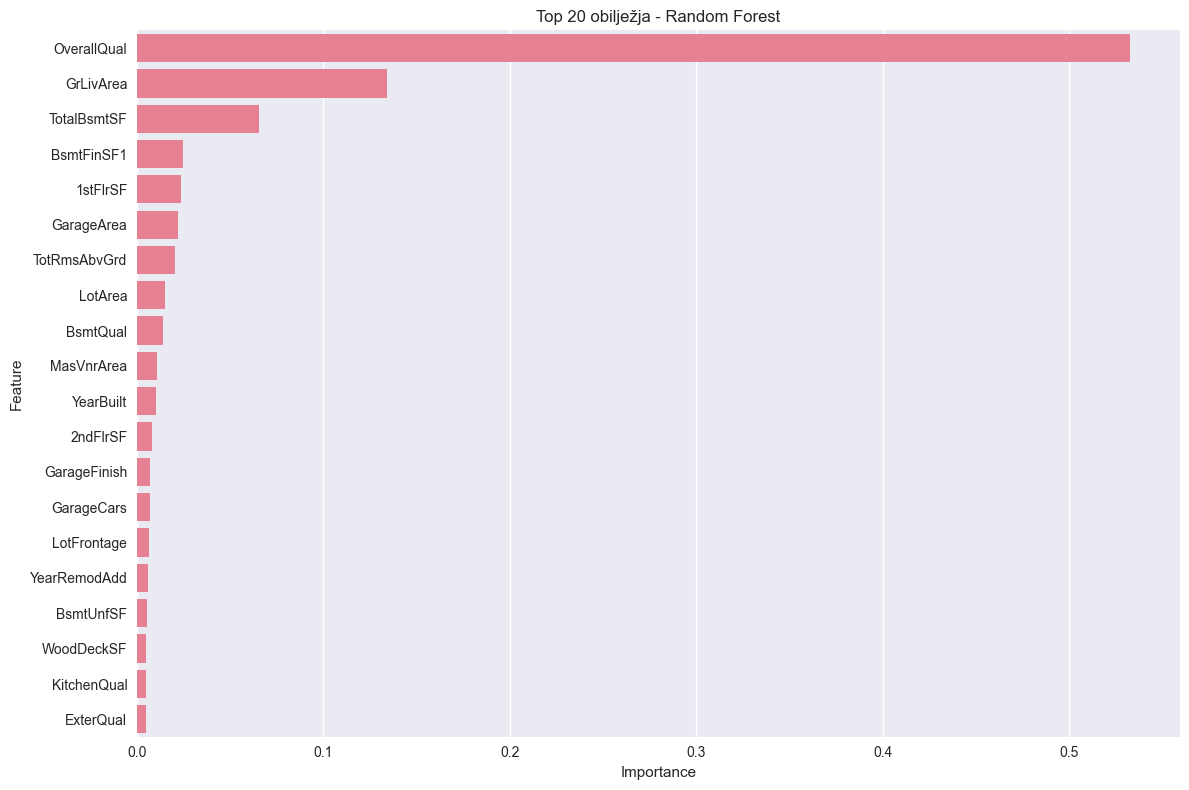

In [6]:
rf_feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.named_steps['randomforestregressor'].feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_imp.head(20))
plt.title('Top 20 obilježja - Random Forest')
plt.tight_layout()
plt.show()

## 7. XGBoost Model

XGBoost (Extreme Gradient Boosting) je moćan algoritam za poboljšanje koji često daje bolje rezultate od Random Forest-a. Slično kao ranije, kreiramo pipeline sa standardizacijom i XGBRegressor-om. Mreža hiperparametara uključuje learning rate (koliko brzo se model adaptira), maksimalnu dubinu stabla i parametre za poduzorkovanje kako bismo spriječili prenaučenost. Koristimo 'reg:squarederror' kao cilj jer je ovo problem regresije. GridSearchCV će pronaći najbolju kombinaciju ovih parametara kroz unakrsnu validaciju.

In [7]:
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
)

xgb_params = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
    'xgbregressor__max_depth': [3, 5, 7],
    'xgbregressor__subsample': [0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTreniranje XGBoost modela...")
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
print("\nNajbolji parametri za XGBoost:")
print(xgb_grid.best_params_)

y_pred_xgb = best_xgb.predict(X_val)
xgb_metrics = evaluate_model(y_val, y_pred_xgb, "XGBoost")


Treniranje XGBoost modela...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Najbolji parametri za XGBoost:
{'xgbregressor__colsample_bytree': 0.8, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 200, 'xgbregressor__subsample': 0.8}

XGBoost Metrike:
MAE: 15169.0485
RMSE: 21960.8173
RMSLE: 0.1182
R2: 0.9170


# 8. XGBoost Značajnost obilježja

Slično analizi za Random Forest, ispitujemo značajnost obilježja za XGBoost. XGBoost izračunava značajnost na osnovu toga koliko često se obilježje koristi za podjelu podataka u svim stablima, ponderisano poboljšanjem u ciljnoj funkciji. Poređenje ovih važnih obilježja sa onima iz Random Forest-a može otkriti dosljedne obrasce ili zanimljive razlike u tome kako dva modela uče iz podataka.

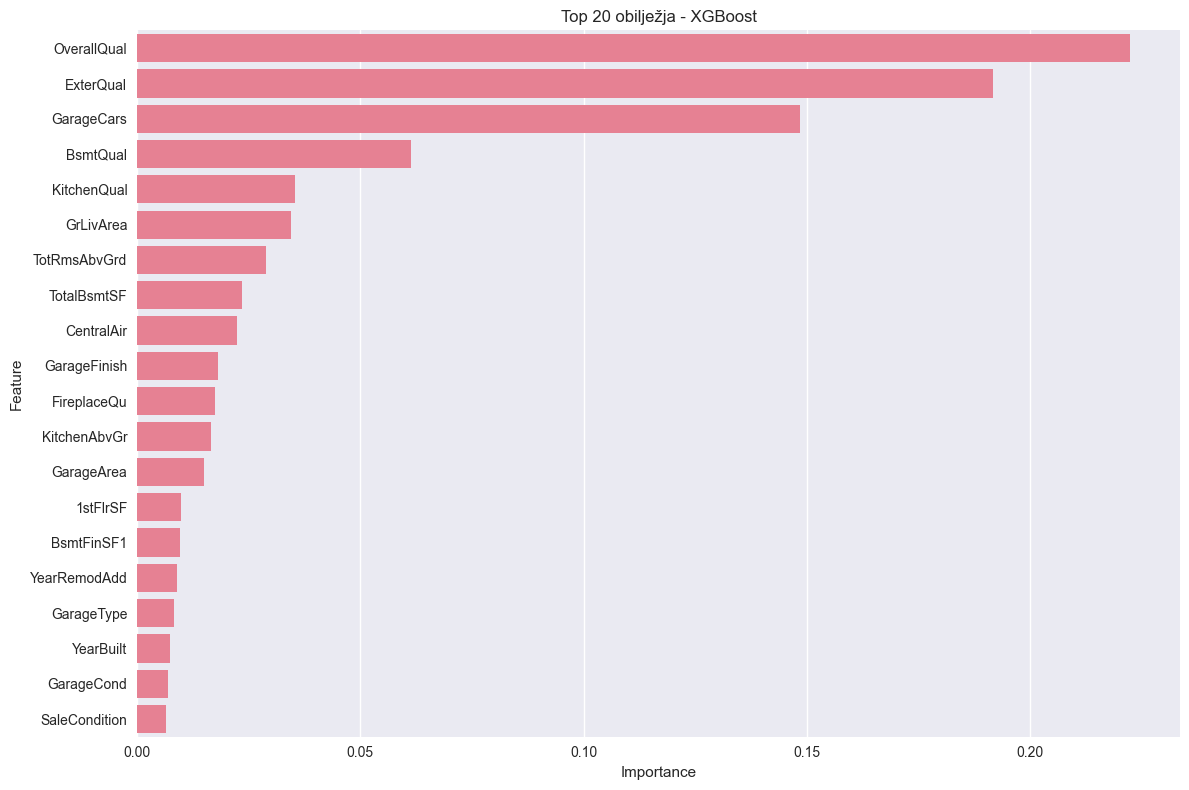

In [8]:
xgb_feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.named_steps['xgbregressor'].feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_imp.head(20))
plt.title('Top 20 obilježja - XGBoost')
plt.tight_layout()
plt.show()

## 9. Poređenje modela i ansambl

Sada ćemo uporediti performanse naša dva modela i istražiti kreiranje jednostavnog ansambla prosječnim predviđanjem. Ansamblovanje često može poboljšati performanse kombinovanjem prednosti različitih modela. Kreiramo DataFrame za uredan prikaz svih metrika jedna pored druge za lakše poređenje.

In [20]:
#y_pred_ensemble = (y_pred_rf + y_pred_xgb) / 2
w_rf = 0.3   # težina za Random Forest
w_xgb = 0.7  # težina za XGBoost (veća težina jer je bolji)

y_pred_ensemble = w_rf * y_pred_rf + w_xgb * y_pred_xgb


ensemble_metrics = evaluate_model(y_val, y_pred_ensemble, "Ensemble (RF + XGB)")



metrics_df = pd.DataFrame({
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'Ensemble': ensemble_metrics
}).T

print("\nPoređenje modela:")
print(metrics_df)


Ensemble (RF + XGB) Metrike:
MAE: 14810.2590
RMSE: 21704.6730
RMSLE: 0.1202
R2: 0.9190

Poređenje modela:
                        MAE          RMSE     RMSLE        R2
Random Forest  15857.553607  23718.031119  0.139294  0.903237
XGBoost        15169.048454  21960.817293  0.118159  0.917044
Ensemble       14810.258957  21704.672966  0.120175  0.918968


# 10. Vizualizacija predviđanja

Vizualizacija stvarnih naspram predviđenih vrijednosti pomaže nam da razumijemo koliko dobro naši modeli rade u različitim rasponima cijena. Kreiramo scatter plot koji upoređuje predviđanja oba modela sa stvarnim vrijednostima, sa crvenom isprekidanom linijom koja predstavlja savršena predviđanja. Ova vizualizacija može otkriti da li naši modeli imaju dosljedne obrasce grešaka kroz spektar cijena ili bolje rade u određenim rasponima cijena.

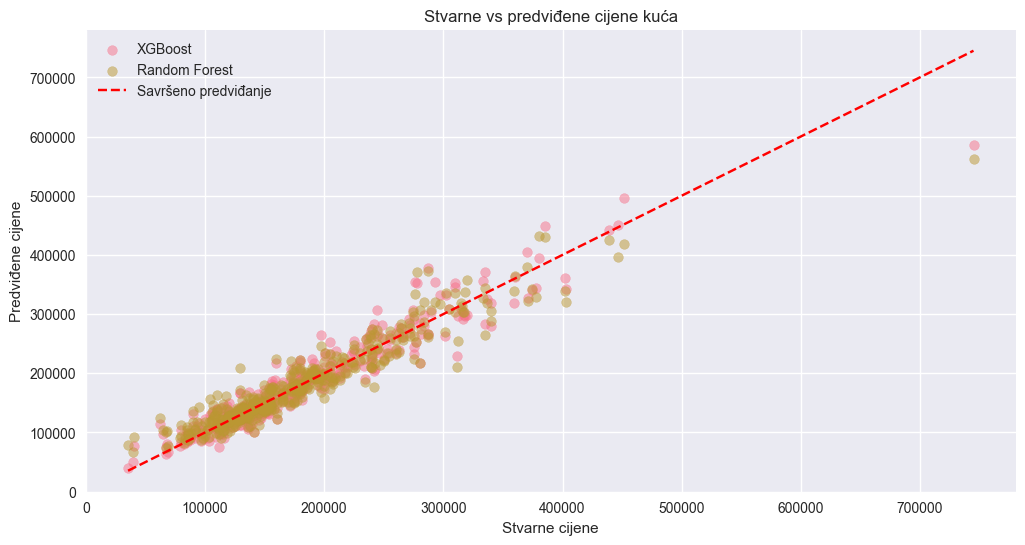

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_xgb, alpha=0.5, label='XGBoost')
plt.scatter(y_val, y_pred_rf, alpha=0.5, label='Random Forest')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', label='Savršeno predviđanje')
plt.xlabel('Stvarne cijene')
plt.ylabel('Predviđene cijene')
plt.title('Stvarne vs predviđene cijene kuća')
plt.legend()
plt.grid(True)
plt.show()

## 11. Treniranje finalnog modela na kompletnim trening podacima

Nakon evaluacije naših modela na validacionom skupu, treniraćemo naš konačni model (XGBoost, koji je imao bolje performanse) na cijelom trening skupu podataka (kombinujući naše prethodne trening i validacione skupove). Ovo daje modelu više podataka za učenje i trebalo bi poboljšati njegovu sposobnost generalizacije. Koristimo najbolje hiperparametre pronađene tokom naše pretrage mreže.

In [11]:
final_model = make_pipeline(
    StandardScaler(),
    XGBRegressor(
        **{k.replace('xgbregressor__', ''): v for k, v in xgb_grid.best_params_.items()},
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror'
    )
)

print("\nTreniranje finalnog modela na kompletnim trening podacima...")
final_model.fit(X_train, y_train)


Treniranje finalnog modela na kompletnim trening podacima...


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=-1, num_parallel_tree=None, predictor=None,
                              random_state=42, ...))])

# 12. Predviđanje na testnom skupu

Važno je napomenuti da nismo dodirivali ovaj testni skup tokom bilo kojeg dijela našeg procesa razvoja modela kako bismo osigurali nepristrasnu evaluaciju.

In [12]:
test_predictions = final_model.predict(X_test)

# 13. Priprema fajla za podnošenje

Formatiraćemo naša predviđanja u traženi format za podnošenje, koji očekuje ID kolonu koja odgovara ID-ovima testnog skupa i naše predviđene SalePrice vrijednosti. ID-ovi počinju od 1461 jer je ovo nastavak trening skupa. Čuvamo ovo u CSV fajl u našem processed_data direktoriju.

In [13]:
submission = pd.DataFrame({
    'Id': range(1461, 1461 + len(X_test)),
    'SalePrice': test_predictions
})

submission_path = '../processed_data/submission_final.csv'
submission.to_csv(submission_path, index=False)
print(f"\nFajl za podnošenje sačuvan na: {submission_path}")


Fajl za podnošenje sačuvan na: ../processed_data/submission_final.csv


## 14. Unakrsna validacija

Da bismo dobili robusniju procjenu performansi našeg modela, vršimo k-fold unakrsnu validaciju na cijelom trening skupu. Ovo nam daje više procjena performansi rotirajući koji dijelovi podataka služe kao validacioni skupovi. Računamo i srednju vrijednost i standardnu devijaciju RMSE skorova kroz foldove da bismo razumjeli i očekivane performanse i njihovu varijabilnost.

In [14]:
def cross_validate_model(model, X, y, cv=5):
    """Izvrši unakrsnu validaciju i prikaži rezultate"""
    scores = cross_val_score(
        model, X, y, 
        cv=cv, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rmse_scores = np.sqrt(-scores)
    
    print(f"\nRezultati {cv}-fold unakrsne validacije:")
    print(f"Srednji RMSE: {rmse_scores.mean():.4f}")
    print(f"Std devijacija: {rmse_scores.std():.4f}")
    
    return rmse_scores

# Izvrši CV na finalnom modelu
cv_scores = cross_validate_model(final_model, X_train, y_train)


Rezultati 5-fold unakrsne validacije:
Srednji RMSE: 24885.5495
Std devijacija: 2431.6505


## 15. Analiza reziduala

Analiza reziduala (razlika između stvarnih i predviđenih vrijednosti) pomaže u dijagnostici potencijalnih problema sa našim modelom. Kreiramo dva grafikona: histogram reziduala da provjerimo da li su normalno distribuirani (kao što bismo željeli), i scatter plot reziduala naspram predviđenih vrijednosti da provjerimo heteroskedastičnost (nekonstantnu varijansu). Obrasci u ovim graficima mogu sugerisati potrebu za različitim pristupima modeliranja ili transformacijama.

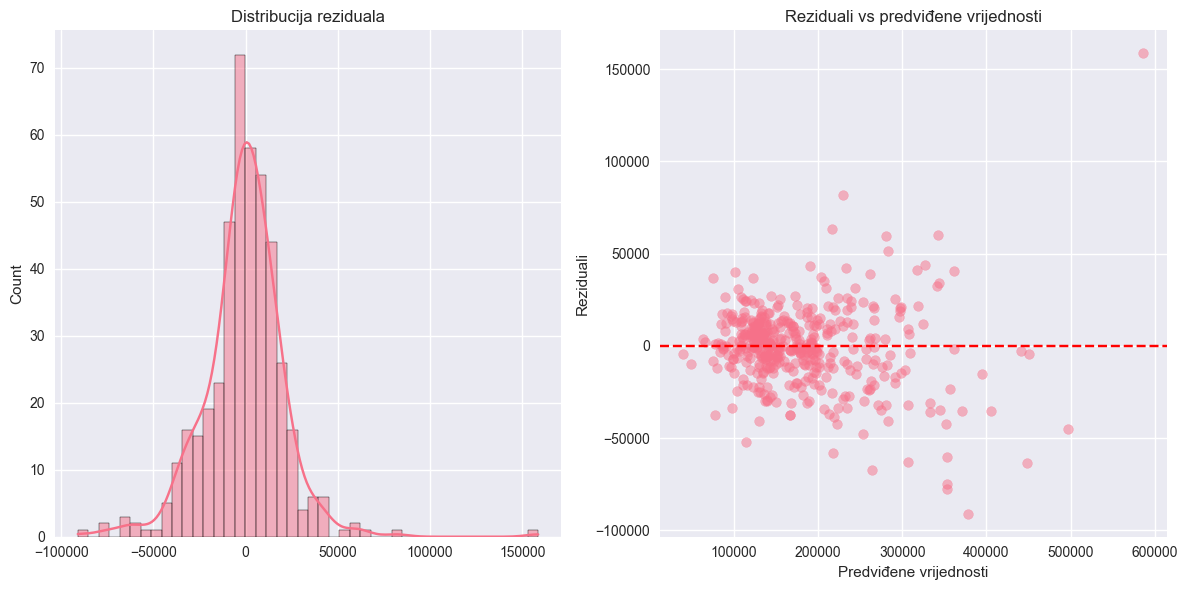

In [15]:
residuals = y_val - y_pred_xgb

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribucija reziduala')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_xgb, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predviđene vrijednosti')
plt.ylabel('Reziduali')
plt.title('Reziduali vs predviđene vrijednosti')
plt.tight_layout()
plt.show()

## 16. Zaključak - Konačno poređenje

Završavamo prikazom naših konačnih metrika poređenja modela i identifikacijom najboljeg modela na osnovu RMSLE. Ovaj sveobuhvatni pregled pomaže da sumiramo naše napore u modeliranju i opravdamo izbor finalnog modela. Poruka o završetku potvrđuje da su svi koraci uspješno izvršeni.

In [16]:
print("\nKonačno poređenje modela:")
print(metrics_df)

best_model = metrics_df['RMSLE'].idxmin()
print(f"\nNajbolji model na osnovu RMSLE: {best_model}")
print(f"RMSLE: {metrics_df.loc[best_model, 'RMSLE']:.4f}")

print("\nProces modeliranja uspješno završen!")


Konačno poređenje modela:
                        MAE          RMSE     RMSLE        R2
Random Forest  15857.553607  23718.031119  0.139294  0.903237
XGBoost        15169.048454  21960.817293  0.118159  0.917044
Ensemble       14805.326496  21918.695165  0.123934  0.917362

Najbolji model na osnovu RMSLE: XGBoost
RMSLE: 0.1182

Proces modeliranja uspješno završen!
